## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import OrderedDict

from sklearn.datasets import fetch_openml            # common data set access
from sklearn.preprocessing import StandardScaler     # scaling transform
from sklearn.model_selection import train_test_split # validation tools
from sklearn.metrics import zero_one_loss
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import SGDClassifier       # Used in 2D data problems
from sklearn.linear_model import LogisticRegression  # Used in MNIST data problem
from sklearn.linear_model import LogisticRegressionCV
import torch
import joblib

seed = 1234
np.random.seed(seed) 

from scipy.ndimage import rotate

## Loading and Scaling Data

In [2]:
# 1. Setup the paths
base_path = "." 
images_folder = os.path.join(base_path, "images")
csv_file = os.path.join(base_path, "legend.csv")

# 2. Read CSV file
df = pd.read_csv(csv_file)

# Lists to store our data
data = []   # This will become X
labels = [] # This will become y

# Define a fixed size for images. For example, MINST is 28*28, here we do 64*64 
IMG_SIZE = 64

print("Loading images... this might take a moment.")

# 3. Loop through the CSV and load images
for index, row in df.iterrows():
    img_name = row['image']
    emotion = row['emotion']

    img_path = os.path.join(images_folder, img_name)

    # Check if file actually exists to avoid errors
    if os.path.exists(img_path):
        # Load image in Grayscale (usually sufficient for emotion detection)
        # If you want color, remove the second argument.
        img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img_array is not None:
            # Resize the image (Crucial step!)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            
            # Flatten the image
            # This converts the 2D image (64x64) into a 1D row of numbers (4096,)
            # This matches the format your professor used for X
            flat_array = new_array.flatten()
            
            data.append(flat_array)
            labels.append(emotion)

# 4. Convert to Numpy Arrays (X and y)
X = np.array(data)
y = np.array(labels)

print("Data loaded successfully!")
print(f"Features (X) shape: {X.shape}") # Should be (Number of images, 4096)
print(f"Labels (y) shape: {y.shape}")    # Should be (Number of images,)


Loading images... this might take a moment.
Data loaded successfully!
Features (X) shape: (13690, 4096)
Labels (y) shape: (13690,)
Data loaded successfully!
Features (X) shape: (13690, 4096)
Labels (y) shape: (13690,)


## **Augmentation Toolkit**
- Build reusable helpers for diverse geometric/photometric transforms.
- Plan to oversample only the training split so each emotion reaches the same count as the majority class (typically happiness/neutral).

In [3]:
def apply_random_transforms(img, rng):
    """Apply a diverse set of randomized geometric and photometric transforms."""
    augmented = img.astype(np.float32)

    if rng.random() < 0.5:
        augmented = np.fliplr(augmented)

    angle = rng.uniform(-15, 15)
    augmented = rotate(augmented, angle=angle, reshape=False, mode='reflect')

    if rng.random() < 0.6:
        alpha = rng.uniform(0.85, 1.25)
        beta = rng.uniform(-12, 12)
        augmented = alpha * augmented + beta

    # Light sharpening only (removed blur to preserve facial details)
    if rng.random() < 0.15:
        blurred = cv2.GaussianBlur(augmented, (3, 3), 0)
        augmented = np.clip(augmented + 0.3 * (augmented - blurred), 0, 255)

    if rng.random() < 0.4:
        noise = rng.normal(0, 8, augmented.shape)
        augmented = augmented + noise

    if rng.random() < 0.4:
        tx = int(rng.integers(-4, 5))
        ty = int(rng.integers(-4, 5))
        transform_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
        augmented = cv2.warpAffine(
            augmented,
            transform_matrix,
            (IMG_SIZE, IMG_SIZE),
            borderMode=cv2.BORDER_REFLECT101
        )

    augmented = np.clip(augmented, 0, 255)
    return augmented.astype(np.float32)


def balance_classes_with_augmentation(X, y, target_count=None, rng_seed=seed):
    """Augment only the provided split until every class reaches target_count samples."""
    X = np.asarray(X)
    y = np.asarray(y)

    class_counts = pd.Series(y).value_counts().sort_index()
    anchor_counts = [class_counts.get(label, class_counts.max()) for label in ("happiness", "neutral")]
    default_target = max(anchor_counts + [class_counts.max()])
    target_count = target_count or default_target

    rng = np.random.default_rng(rng_seed)
    new_samples = []
    new_labels = []

    for label, count in class_counts.items():
        needed = int(max(0, target_count - count))
        if needed == 0:
            continue

        label_indices = np.where(y == label)[0]
        for _ in range(needed):
            base_idx = rng.choice(label_indices)
            base_img = X[base_idx].reshape(IMG_SIZE, IMG_SIZE)
            augmented_img = apply_random_transforms(base_img, rng)
            new_samples.append(augmented_img.flatten())
            new_labels.append(label)

    if new_samples:
        augmented_X = np.vstack((X.astype(np.float32), np.array(new_samples, dtype=np.float32)))
        augmented_y = np.concatenate((y, np.array(new_labels)))
    else:
        augmented_X = X.astype(np.float32)
        augmented_y = y

    augmented_counts = pd.Series(augmented_y).value_counts().sort_index()
    return augmented_X, augmented_y, class_counts, augmented_counts, target_count

In [4]:
def summarize_counts(labels, title):
    counts = pd.Series(labels).value_counts().sort_index()
    print(f"=== {title} ===")
    print(counts)
    print(f"Total samples: {counts.sum():,}\n")
    return counts


base_counts = summarize_counts(y, "Original dataset distribution")
anchor_target = max(
    base_counts.get("happiness", base_counts.max()),
    base_counts.get("neutral", base_counts.max())
)
print(f"Anchor target per class (matching happiness/neutral): {anchor_target}")

=== Original dataset distribution ===
anger         252
contempt        9
disgust       208
fear           21
happiness    5696
neutral      6868
sadness       268
suprise       368
Name: count, dtype: int64
Total samples: 13,690

Anchor target per class (matching happiness/neutral): 6868


In [5]:
def plot_class_counts(before_counts, after_counts, title):
    labels = sorted(set(before_counts.index).union(after_counts.index))
    before = [before_counts.get(lbl, 0) for lbl in labels]
    after = [after_counts.get(lbl, 0) for lbl in labels]

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(12, 5))
    plt.bar(x - width / 2, before, width, label="Before")
    plt.bar(x + width / 2, after, width, label="After")
    plt.xticks(x, labels, rotation=45)
    plt.ylabel("Samples")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


def preview_random_augmentations(X, y, label=None, samples=3, rng_seed=seed):
    rng = np.random.default_rng(rng_seed)
    if label is None:
        label = rng.choice(np.unique(y))

    label_indices = np.where(y == label)[0]
    if len(label_indices) == 0:
        print(f"Label '{label}' not found in the provided data.")
        return

    plt.figure(figsize=(samples * 3, 4))
    for i in range(samples):
        idx = rng.choice(label_indices)
        original_img = X[idx].reshape(IMG_SIZE, IMG_SIZE)
        augmented_img = apply_random_transforms(original_img, rng)

        plt.subplot(2, samples, i + 1)
        plt.imshow(original_img, cmap="gray")
        plt.axis("off")
        plt.title(f"{label} original")

        plt.subplot(2, samples, samples + i + 1)
        plt.imshow(augmented_img, cmap="gray")
        plt.axis("off")
        plt.title(f"{label} augmented")

    plt.suptitle(f"Random augmentations for '{label}'")
    plt.tight_layout()
    plt.show()

Previewing augmentation effects for minority label: contempt


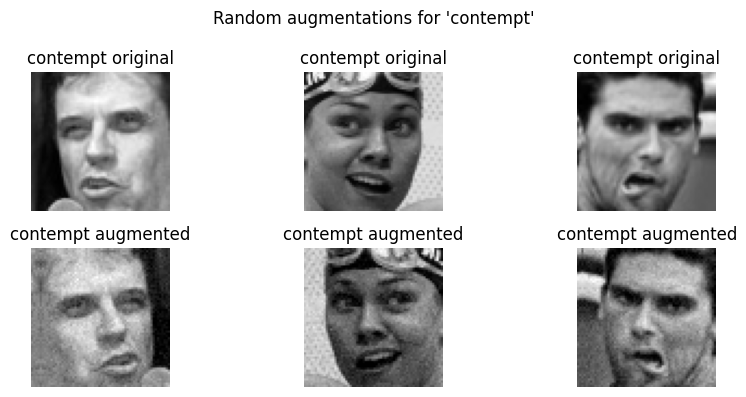


Previewing augmentation effects for common label: happiness


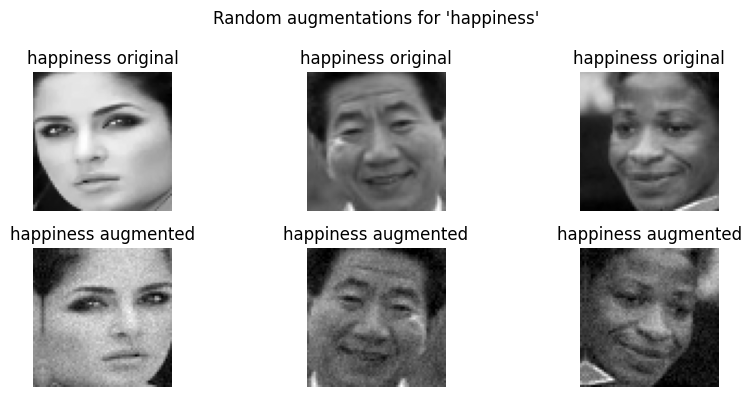

In [6]:
rare_label = base_counts.idxmin()
common_label = "happiness" if "happiness" in base_counts.index else base_counts.idxmax()

print(f"Previewing augmentation effects for minority label: {rare_label}")
preview_random_augmentations(X, y, label=rare_label, samples=3)

print(f"\nPreviewing augmentation effects for common label: {common_label}")
preview_random_augmentations(X, y, label=common_label, samples=3)

In [7]:
needed_per_label = base_counts.apply(lambda c: max(0, anchor_target - c)).sort_values(ascending=False)
print("=== Samples needed per label to match anchor target ===")
print(needed_per_label)
print("\nThese counts determine how many synthetic examples each class will receive once we augment the training split.")

=== Samples needed per label to match anchor target ===
contempt     6859
fear         6847
disgust      6660
anger        6616
sadness      6600
suprise      6500
happiness    1172
neutral         0
Name: count, dtype: int64

These counts determine how many synthetic examples each class will receive once we augment the training split.


### Balanced augmentation strategy

- All images remain grayscale 64×64, but we now apply a richer transform palette: random flips, ±15° rotations, brightness/contrast jitter, Gaussian blur or sharpening, small translations, and gentle Gaussian noise. Each call produces a unique variant rather than deterministic duplicates.
- We only augment the **training split**. Validation and test images stay untouched so performance estimates remain honest.
- Every class is oversampled until it matches the anchor size defined by the most common label (`happiness` or `neutral` in this dataset). Rare emotions therefore receive more synthetic samples than already-balanced ones.
- Augmented samples are concatenated with the original training set before scaling; `StandardScaler` is still fit exclusively on that (now larger) training data and then applied to validation/test splits.
- Helper utilities report class counts before/after augmentation and let us visualize random augmented examples for any label to ensure the transforms look reasonable.

## Training Data Splitting

=== Data Split Summary ===
Training set:   9,583 samples (70.0%)
Validation set: 2,053 samples (15.0%)
Test set:       2,054 samples (15.0%)
Total:          13,690 samples

=== Training split counts before augmentation ===
anger         176
contempt        6
disgust       146
fear           15
happiness    3987
neutral      4807
sadness       188
suprise       258
Name: count, dtype: int64

Target per class for training augmentation: 4807

=== Training split counts after augmentation ===
anger        4807
contempt     4807
disgust      4807
fear         4807
happiness    4807
neutral      4807
sadness      4807
suprise      4807
Name: count, dtype: int64
Total augmented training samples: 38,456 (added 28,873)

=== Training split counts after augmentation ===
anger        4807
contempt     4807
disgust      4807
fear         4807
happiness    4807
neutral      4807
sadness      4807
suprise      4807
Name: count, dtype: int64
Total augmented training samples: 38,456 (added 28,873)


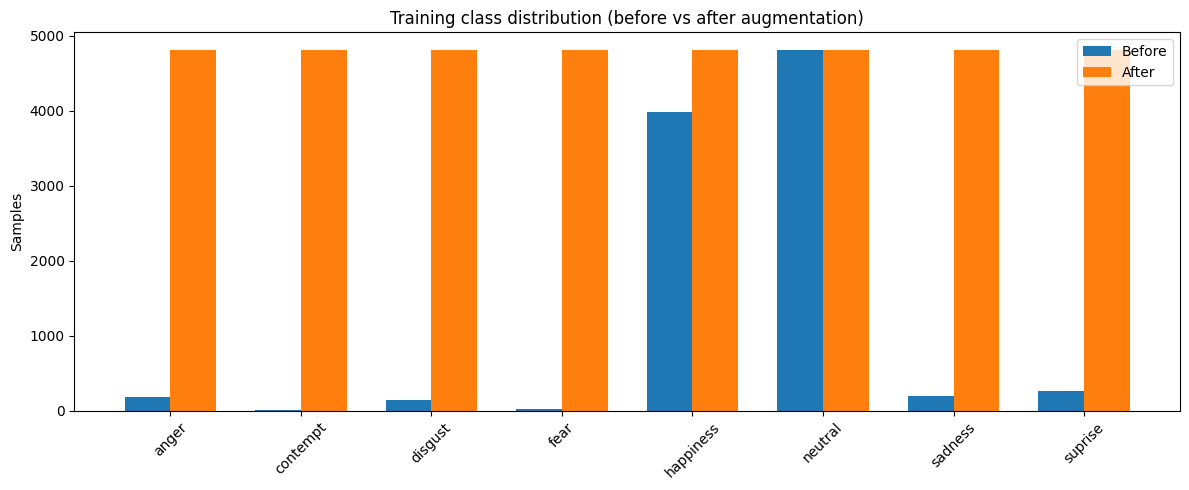

Scaling complete. Validation/test sets remain unaugmented to avoid leakage.


In [8]:
# Split strategy: 70% train, 15% validation, 15% test
# Using stratified sampling to maintain class proportions (for imbalanced "disgust" class)

# First split: 70% train, 30% temp (which will become val + test)
X_tr, X_temp, y_tr, y_temp = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=seed,
    shuffle=True,
    stratify=y
)

# Second split: Split the 30% temp into 50/50 -> 15% val, 15% test
X_val, X_te, y_val, y_te = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    random_state=seed,
    shuffle=True,
    stratify=y_temp
)

print("=== Data Split Summary ===")
print(f"Training set:   {X_tr.shape[0]:,} samples ({X_tr.shape[0] / len(X) * 100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0] / len(X) * 100:.1f}%)")
print(f"Test set:       {X_te.shape[0]:,} samples ({X_te.shape[0] / len(X) * 100:.1f}%)")
print(f"Total:          {len(X):,} samples\n")

train_counts_before = pd.Series(y_tr).value_counts().sort_index()
print("=== Training split counts before augmentation ===")
print(train_counts_before)

train_target = max(
    train_counts_before.get("happiness", train_counts_before.max()),
    train_counts_before.get("neutral", train_counts_before.max())
)
print(f"\nTarget per class for training augmentation: {train_target}")

X_tr_bal, y_tr_bal, before_counts, after_counts, _ = balance_classes_with_augmentation(
    X_tr,
    y_tr,
    target_count=train_target,
    rng_seed=seed
)

print("\n=== Training split counts after augmentation ===")
print(after_counts)
print(f"Total augmented training samples: {X_tr_bal.shape[0]:,} (added {X_tr_bal.shape[0] - X_tr.shape[0]:,})")

plot_class_counts(before_counts, after_counts, "Training class distribution (before vs after augmentation)")

# Scaling - fit ONLY on the augmented training data, transform all sets
scaler = StandardScaler()
scaler.fit(X_tr_bal)
X_tr = scaler.transform(X_tr_bal)
X_val = scaler.transform(X_val)
X_te = scaler.transform(X_te)
y_tr = y_tr_bal

print("Scaling complete. Validation/test sets remain unaugmented to avoid leakage.")

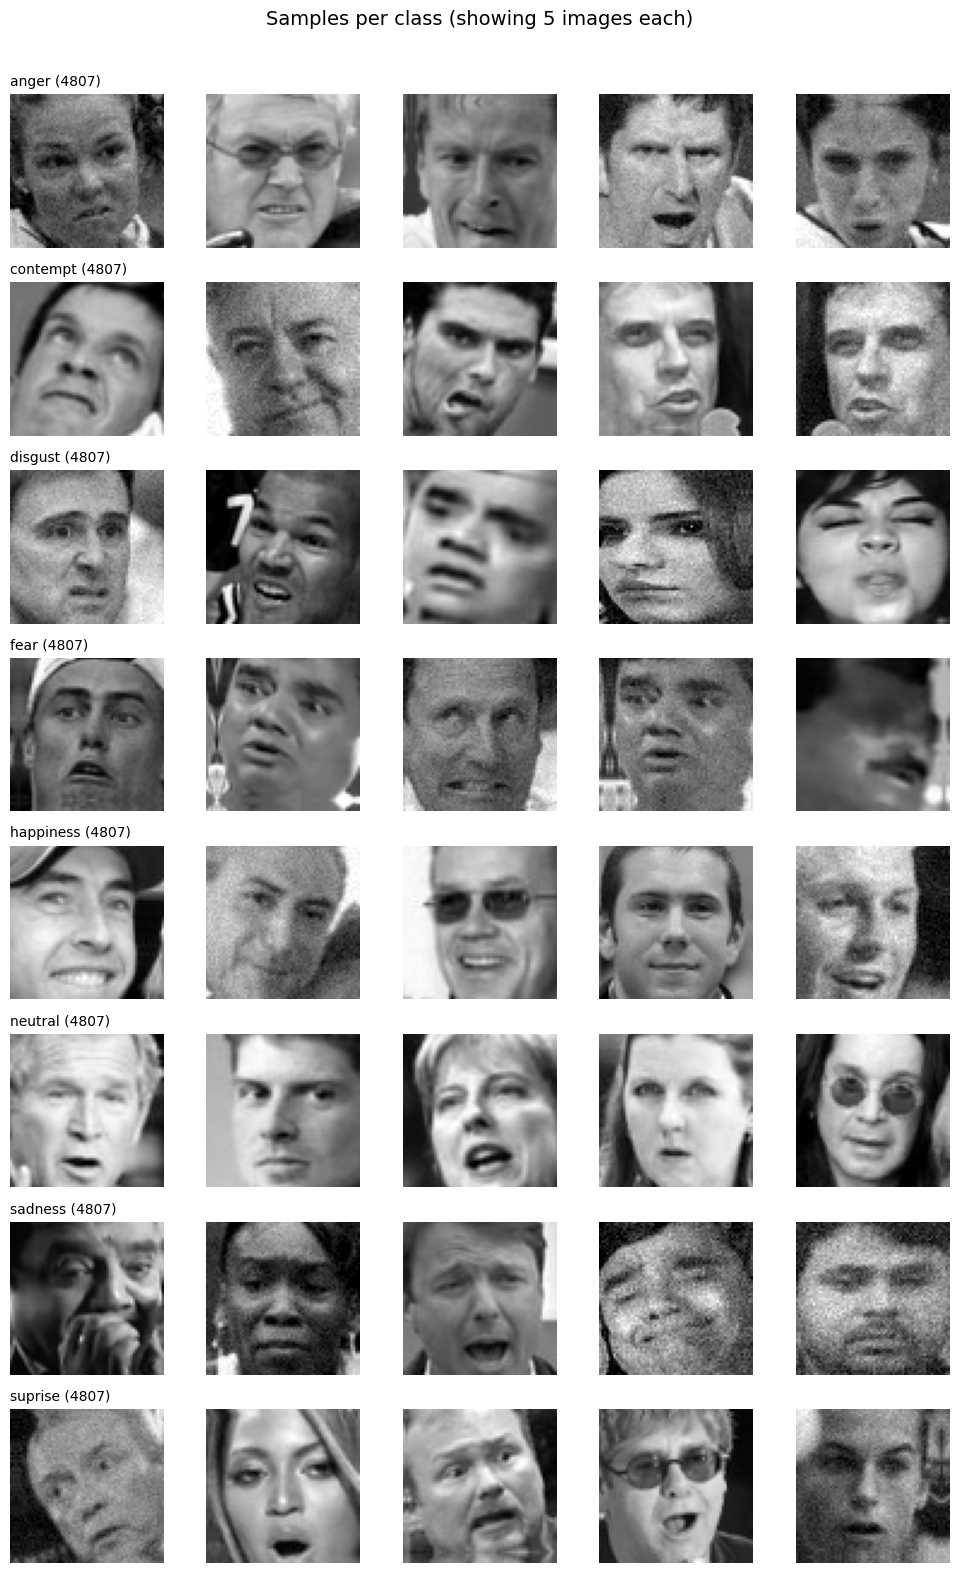

In [9]:
def plot_samples_per_class(X, y, classes=None, samples_per_class=5, seed=seed):
    """
    Plot a grid of sample images for each class (rows = class, cols = samples).
    X: flattened images (N, 4096)
    y: labels (N,)
    classes: list-like class names to show (default: all unique labels)
    samples_per_class: number of samples to show per class
    """
    classes = list(classes) if classes is not None else sorted(np.unique(y))
    rng = np.random.default_rng(seed)

    n_classes = len(classes)
    cols = samples_per_class
    rows = n_classes

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.0, rows * 2.0))
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = axes[np.newaxis, :]
    elif cols == 1:
        axes = axes[:, np.newaxis]

    for i, cls in enumerate(classes):
        idxs = np.where(y == cls)[0]
        if idxs.size == 0:
            for j in range(cols):
                ax = axes[i, j]
                ax.axis("off")
            continue

        if idxs.size >= cols:
            sel = rng.choice(idxs, size=cols, replace=False)
        else:
            sel = rng.choice(idxs, size=cols, replace=True)

        for j in range(cols):
            ax = axes[i, j]
            img = X[sel[j]].reshape((IMG_SIZE, IMG_SIZE))
            # If the X is scaled rather than uint8, normalize for display
            if np.issubdtype(img.dtype, np.floating):
                # map to 0-1 for grayscale display
                if img.max() > img.min():
                    img_disp = (img - img.min()) / (img.max() - img.min())
                else:
                    img_disp = img
                ax.imshow(img_disp, cmap="gray")
            else:
                ax.imshow(img, cmap="gray", vmin=0, vmax=255)
            ax.axis("off")
            if j == 0:
                ax.set_title(f"{cls} ({len(idxs)})", fontsize=10, loc="left")

    plt.suptitle(f"Samples per class (showing {samples_per_class} images each)", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


# Preview 5 images per class from the original dataset
labels_unique = sorted(np.unique(y_tr_bal))
plot_samples_per_class(X_tr_bal, y_tr_bal, classes=labels_unique, samples_per_class=5)

In [10]:
models_dir = os.path.join(base_path, "models")
os.makedirs(models_dir, exist_ok=True)


def save_model_checkpoint(model: nn.Module, prefix: str, epoch: int, is_best: bool = False) -> str:
    """Persist model weights (CPU tensors) under models/ with an epoch or best suffix."""
    tag = "best" if is_best else f"epoch_{epoch:02d}"
    path = os.path.join(models_dir, f"{prefix}_{tag}.joblib")
    state_dict_cpu = OrderedDict((k, v.detach().cpu()) for k, v in model.state_dict().items())
    payload = {
        "epoch": int(epoch),
        "state_dict": state_dict_cpu,
        "prefix": prefix,
    }
    joblib.dump(payload, path, compress=3)
    return path

## CNN on Augmented 64×64 Data
We now reuse Nickolas' augmented training split to train Mihir's PyTorch CNN. Images stay 64×64, we normalize them to [0,1], and keep validation/test data untouched by augmentation to preserve proper evaluation.


In [11]:
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader


def reshape_and_normalize(flat_images):
    images = flat_images.reshape(-1, 1, IMG_SIZE, IMG_SIZE).astype(np.float32)
    return images / 255.0


X_tr_cnn = reshape_and_normalize(X_tr_bal)
X_val_unscaled = scaler.inverse_transform(X_val)
X_te_unscaled = scaler.inverse_transform(X_te)
X_val_cnn = reshape_and_normalize(X_val_unscaled)
X_te_cnn = reshape_and_normalize(X_te_unscaled)

le = LabelEncoder()
le.fit(y)
y_tr_enc = le.transform(y_tr_bal)
y_val_enc = le.transform(y_val)
y_te_enc = le.transform(y_te)

print("CNN tensors ready:")
print(f"Train: {X_tr_cnn.shape} | Val: {X_val_cnn.shape} | Test: {X_te_cnn.shape}")
print("Classes:", le.classes_)


CNN tensors ready:
Train: (38456, 1, 64, 64) | Val: (2053, 1, 64, 64) | Test: (2054, 1, 64, 64)
Classes: ['anger' 'contempt' 'disgust' 'fear' 'happiness' 'neutral' 'sadness'
 'suprise']


In [12]:
batch_size = 128
pin_memory_flag = torch.cuda.is_available()

train_dataset = TensorDataset(torch.tensor(X_tr_cnn), torch.tensor(y_tr_enc, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val_cnn), torch.tensor(y_val_enc, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_te_cnn), torch.tensor(y_te_enc, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=pin_memory_flag)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=pin_memory_flag)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=pin_memory_flag)

for images, labels in train_loader:
    print("Sample batch:", images.shape, labels.shape)
    break

Sample batch: torch.Size([128, 1, 64, 64]) torch.Size([128])


In [13]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)


num_classes = len(le.classes_)
model = EmotionCNN(num_classes)
print(model)


EmotionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=8, bias=True)
)


In [14]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

torch.set_float32_matmul_precision("high")
print("Using device:", device)

model = EmotionCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 25
checkpoint_prefix = "simple_cnn"
train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_val_acc = 0.0
best_state = None
best_checkpoint_path = None

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    save_model_checkpoint(model, checkpoint_prefix, epoch)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = OrderedDict((k, v.detach().cpu()) for k, v in model.state_dict().items())
        best_checkpoint_path = save_model_checkpoint(model, checkpoint_prefix, epoch, is_best=True)

    print(f"Epoch {epoch:02d}/{epochs} | Train Loss {train_loss:.4f} | Train Acc {train_acc*100:5.2f}% | "
          f"Val Loss {val_loss:.4f} | Val Acc {val_acc*100:5.2f}%")

if best_state is not None:
    model.load_state_dict(best_state)
    if best_checkpoint_path:
        print(f"\nLoaded best model with validation accuracy {best_val_acc*100:.2f}% (checkpoint: {best_checkpoint_path})")
    else:
        print(f"\nLoaded best model with validation accuracy {best_val_acc*100:.2f}%")

Using device: mps
Epoch 01/25 | Train Loss 1.6859 | Train Acc 37.18% | Val Loss 1.2541 | Val Acc 59.57%
Epoch 01/25 | Train Loss 1.6859 | Train Acc 37.18% | Val Loss 1.2541 | Val Acc 59.57%
Epoch 02/25 | Train Loss 1.1362 | Train Acc 56.98% | Val Loss 0.9782 | Val Acc 68.44%
Epoch 02/25 | Train Loss 1.1362 | Train Acc 56.98% | Val Loss 0.9782 | Val Acc 68.44%
Epoch 03/25 | Train Loss 0.9720 | Train Acc 63.14% | Val Loss 0.7953 | Val Acc 73.79%
Epoch 03/25 | Train Loss 0.9720 | Train Acc 63.14% | Val Loss 0.7953 | Val Acc 73.79%
Epoch 04/25 | Train Loss 0.8504 | Train Acc 67.58% | Val Loss 0.6895 | Val Acc 77.11%
Epoch 04/25 | Train Loss 0.8504 | Train Acc 67.58% | Val Loss 0.6895 | Val Acc 77.11%
Epoch 05/25 | Train Loss 0.7630 | Train Acc 70.50% | Val Loss 0.8310 | Val Acc 71.99%
Epoch 05/25 | Train Loss 0.7630 | Train Acc 70.50% | Val Loss 0.8310 | Val Acc 71.99%
Epoch 06/25 | Train Loss 0.6986 | Train Acc 72.91% | Val Loss 0.7159 | Val Acc 76.47%
Epoch 06/25 | Train Loss 0.6986 | Tr

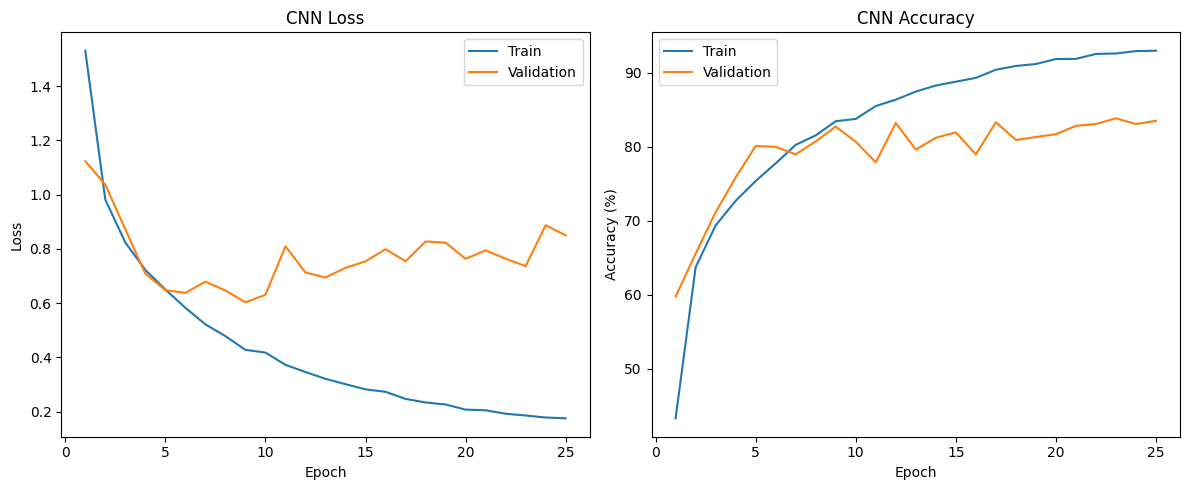

In [48]:
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train")
plt.plot(epochs_range, val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, [acc * 100 for acc in train_accs], label="Train")
plt.plot(epochs_range, [acc * 100 for acc in val_accs], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("CNN Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


In [49]:
def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            preds = model(X_batch).argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total

val_accuracy = evaluate(val_loader)
test_accuracy = evaluate(test_loader)

print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Validation Error Rate: {(1 - val_accuracy)*100:.2f}%")
print(f"Test Error Rate: {(1 - test_accuracy)*100:.2f}%")
if 'best_checkpoint_path' in globals() and best_checkpoint_path:
    print(f"Best simple CNN checkpoint: {best_checkpoint_path}")

Validation Accuracy: 83.83%
Test Accuracy: 84.91%
Validation Error Rate: 16.17%
Test Error Rate: 15.09%
Best simple CNN checkpoint: ./models/simple_cnn_best.joblib


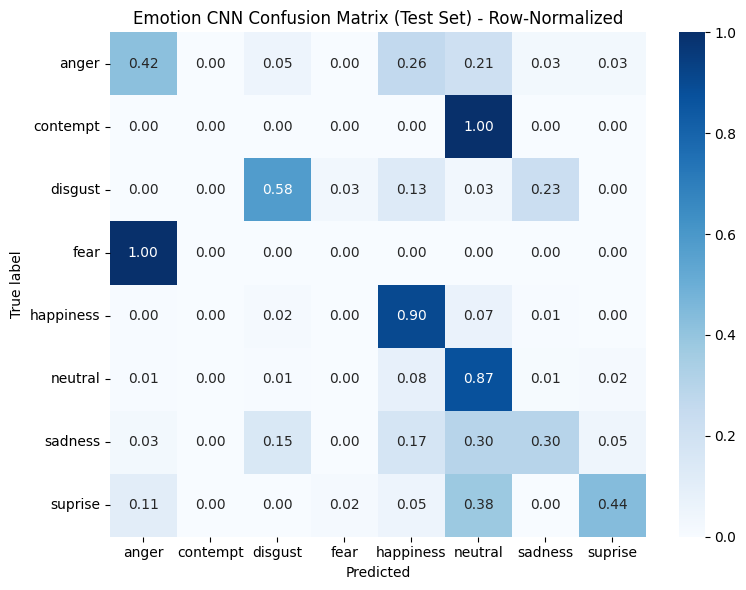

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(y_batch.numpy())

cm = confusion_matrix(all_targets, all_preds)

# Normalize each row by its sum to get percentages relative to true label count
cm_normalized = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_, vmin=0, vmax=1)
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.title('Emotion CNN Confusion Matrix (Test Set) - Row-Normalized')
plt.tight_layout()
plt.show()

## Accuracy Improvement Strategy
- Keep augmenting only the training split but switch to *online* transforms so the model sees different variants every epoch instead of a fixed oversampled copy.
- Combine geometric (flip/rotate/translate), photometric (contrast/brightness/blur/sharpen), and regularization tricks like RandomErasing plus optional MixUp to better cover inter-class variation.
- Replace the shallow CNN with a residual-style network that stacks squeeze-excitation blocks, deeper feature hierarchies, dropout, and adaptive pooling so capacity matches the harder classes without exploding parameters.
- Use modern training hygiene: label smoothing, cosine LR decay + warm restarts (or ReduceLROnPlateau), gradient clipping, and AMP to stabilize convergence.
- Track validation metrics for early stopping and keep the best checkpoint before evaluating on the untouched test set.

## Residual CNN + Online Augmentation
We now build a stronger training pipeline that keeps generating fresh augmentations every epoch, mixes labels for additional regularization, and feeds a squeeze-excitation residual network that is deeper than the earlier CNN but still lightweight enough for 64×64 inputs.

In [51]:
from typing import Callable, Iterable, Optional, Tuple

from PIL import Image
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.amp as amp

In [52]:
def to_uint8_images(flat_images: np.ndarray) -> np.ndarray:
    """Reshape flattened 64×64 arrays and clamp to [0, 255] uint8 for PIL transforms."""
    reshaped = flat_images.reshape(-1, IMG_SIZE, IMG_SIZE)
    return np.clip(reshaped, 0, 255).astype(np.uint8)


class EmotionArrayDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        flat_images: np.ndarray,
        labels: Iterable[int],
        transform: Optional[Callable] = None,
    ) -> None:
        self.images = to_uint8_images(flat_images)
        self.labels = np.asarray(labels, dtype=np.int64)
        self.transform = transform

    def __len__(self) -> int:
        return self.labels.shape[0]

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        img = Image.fromarray(self.images[idx])
        tensor = self.transform(img) if self.transform else transforms.ToTensor()(img)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return tensor, label


strong_train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.05), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.RandomRotation(18, fill=0)], p=0.7),
    transforms.RandomApply([transforms.RandomAffine(0, translate=(0.08, 0.08), shear=6, fill=0)], p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.35, contrast=0.35)], p=0.6),
    transforms.RandomAdjustSharpness(sharpness_factor=1.3, p=0.15),  # Reduced sharpening
    transforms.ToTensor(),  # Removed Gaussian blur to keep features sharp
    transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.15), ratio=(0.3, 3.3), value=0.0),
])


eval_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])


adv_batch_size = 128
pin_memory = torch.cuda.is_available()
num_workers = 0  # keep inline dataset definitions pickle-safe for notebook DataLoader workers

adv_train_dataset = EmotionArrayDataset(X_tr_bal, y_tr_enc, transform=strong_train_transforms)
adv_val_dataset = EmotionArrayDataset(X_val_unscaled, y_val_enc, transform=eval_transforms)
adv_test_dataset = EmotionArrayDataset(X_te_unscaled, y_te_enc, transform=eval_transforms)

adv_train_loader = DataLoader(
    adv_train_dataset,
    batch_size=adv_batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
adv_val_loader = DataLoader(
    adv_val_dataset,
    batch_size=adv_batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
adv_test_loader = DataLoader(
    adv_test_dataset,
    batch_size=adv_batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

print(f"Advanced pipeline | Train {len(adv_train_dataset):,} | Val {len(adv_val_dataset):,} | Test {len(adv_test_dataset):,}")

Advanced pipeline | Train 38,456 | Val 2,053 | Test 2,054


In [53]:
class SEBlock(nn.Module):
    def __init__(self, channels: int, reduction: int = 16) -> None:
        super().__init__()
        bottleneck = max(1, channels // reduction)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, bottleneck, kernel_size=1, bias=True),
            nn.SiLU(),
            nn.Conv2d(bottleneck, channels, kernel_size=1, bias=True),
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        scale = self.fc(self.pool(x))
        return x * scale


class ResidualBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        dropout: float = 0.0,
    ) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels)
        self.dropout = nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        out = F.relu(out + identity)
        return out


class EmotionResNet(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.SiLU(),
            nn.MaxPool2d(2),
        )

        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1, dropout=0.05)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2, dropout=0.1)
        self.layer3 = self._make_layer(128, 192, blocks=2, stride=2, dropout=0.15)
        self.layer4 = self._make_layer(192, 256, blocks=2, stride=2, dropout=0.15)

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.LayerNorm(256),
            nn.Dropout(0.4),
            nn.Linear(256, 256),
            nn.SiLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
        )

        self.apply(self._init_weights)

    def _make_layer(self, in_c: int, out_c: int, blocks: int, stride: int, dropout: float) -> nn.Sequential:
        layers = [ResidualBlock(in_c, out_c, stride=stride, dropout=dropout)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_c, out_c, stride=1, dropout=dropout))
        return nn.Sequential(*layers)

    @staticmethod
    def _init_weights(m: nn.Module) -> None:
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
        elif isinstance(m, (nn.BatchNorm2d, nn.LayerNorm)):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return self.head(x)


print(EmotionResNet(num_classes))

EmotionResNet(
  (stem): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SiLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock(
        (pool): AdaptiveAvgPool2d(output_size=1)
  

In [54]:
def mixup_data(inputs: torch.Tensor, targets: torch.Tensor, alpha: float) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, float]:
    if alpha <= 0:
        return inputs, targets, targets, 1.0
    lam = np.random.beta(alpha, alpha)
    index = torch.randperm(inputs.size(0), device=inputs.device)
    mixed_inputs = lam * inputs + (1.0 - lam) * inputs[index]
    targets_a, targets_b = targets, targets[index]
    return mixed_inputs, targets_a, targets_b, lam


def evaluate_model(model: nn.Module, loader: DataLoader, criterion: nn.Module) -> Tuple[float, float]:
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(loader), correct / total


def train_residual_model(
    epochs: int = 35,
    mixup_alpha: float = 0.2,
    lr: float = 3e-4,
    weight_decay: float = 1e-4,
    grad_clip: float = 1.0,
    checkpoint_prefix: str = "residual_cnn",
) -> Tuple[nn.Module, list, Optional[str]]:
    model = EmotionResNet(num_classes).to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=5e-6)

    amp_enabled = device.type == "cuda"
    scaler_amp = amp.GradScaler(enabled=amp_enabled) if amp_enabled else None

    history = []
    best_state = None
    best_val_acc = 0.0
    best_checkpoint_path: Optional[str] = None

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss, running_correct, total = 0.0, 0, 0

        for step, (images, labels) in enumerate(adv_train_loader, start=1):
            images = images.to(device)
            labels = labels.to(device)

            mixed_images, targets_a, targets_b, lam = mixup_data(images, labels, mixup_alpha)

            optimizer.zero_grad(set_to_none=True)
            autocast_context = amp.autocast(device_type="cuda", enabled=amp_enabled)
            with autocast_context:
                outputs = model(mixed_images)
                if mixup_alpha > 0:
                    loss = lam * criterion(outputs, targets_a) + (1.0 - lam) * criterion(outputs, targets_b)
                else:
                    loss = criterion(outputs, labels)

            if amp_enabled and scaler_amp is not None:
                scaler_amp.scale(loss).backward()
                if grad_clip > 0:
                    scaler_amp.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                scaler_amp.step(optimizer)
                scaler_amp.update()
            else:
                loss.backward()
                if grad_clip > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                optimizer.step()

            progress = epoch - 1 + step / len(adv_train_loader)
            scheduler.step(progress)

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            running_correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(adv_train_loader)
        train_acc = running_correct / total
        val_loss, val_acc = evaluate_model(model, adv_val_loader, criterion)

        history.append(
            {
                "epoch": epoch,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "lr": optimizer.param_groups[0]["lr"],
            }
        )

        save_model_checkpoint(model, checkpoint_prefix, epoch)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = OrderedDict((k, v.detach().cpu()) for k, v in model.state_dict().items())
            best_checkpoint_path = save_model_checkpoint(model, checkpoint_prefix, epoch, is_best=True)

        print(
            f"Epoch {epoch:02d}/{epochs} | Train Loss {train_loss:.4f} | Train Acc {train_acc*100:5.2f}% | "
            f"Val Loss {val_loss:.4f} | Val Acc {val_acc*100:5.2f}% | LR {optimizer.param_groups[0]['lr']:.2e}"
        )

    if best_state is not None:
        model.load_state_dict(best_state)
        if best_checkpoint_path:
            print(f"Loaded best checkpoint (val acc {best_val_acc*100:.2f}%) -> {best_checkpoint_path}")
        else:
            print(f"Loaded best checkpoint (val acc {best_val_acc*100:.2f}%)")

    return model, history, best_checkpoint_path

In [55]:
adv_epochs = 30
mixup_alpha = 0.3
advanced_model, advanced_history, advanced_best_path = train_residual_model(
    epochs=adv_epochs,
    mixup_alpha=mixup_alpha,
    lr=3e-4,
    weight_decay=2e-4,
    grad_clip=1.0,
    checkpoint_prefix="residual_cnn",
)

Epoch 01/30 | Train Loss 1.7798 | Train Acc 24.93% | Val Loss 1.5786 | Val Acc 43.30% | LR 2.72e-04
Epoch 02/30 | Train Loss 1.4043 | Train Acc 36.16% | Val Loss 1.0778 | Val Acc 67.61% | LR 1.98e-04
Epoch 02/30 | Train Loss 1.4043 | Train Acc 36.16% | Val Loss 1.0778 | Val Acc 67.61% | LR 1.98e-04
Epoch 03/30 | Train Loss 1.3198 | Train Acc 41.15% | Val Loss 0.9992 | Val Acc 72.58% | LR 1.07e-04
Epoch 03/30 | Train Loss 1.3198 | Train Acc 41.15% | Val Loss 0.9992 | Val Acc 72.58% | LR 1.07e-04
Epoch 04/30 | Train Loss 1.2489 | Train Acc 43.58% | Val Loss 0.9730 | Val Acc 73.40% | LR 3.32e-05
Epoch 04/30 | Train Loss 1.2489 | Train Acc 43.58% | Val Loss 0.9730 | Val Acc 73.40% | LR 3.32e-05
Epoch 05/30 | Train Loss 1.2365 | Train Acc 42.99% | Val Loss 0.9454 | Val Acc 75.01% | LR 3.00e-04
Epoch 05/30 | Train Loss 1.2365 | Train Acc 42.99% | Val Loss 0.9454 | Val Acc 75.01% | LR 3.00e-04
Epoch 06/30 | Train Loss 1.2335 | Train Acc 41.71% | Val Loss 0.9447 | Val Acc 75.55% | LR 2.93e-04


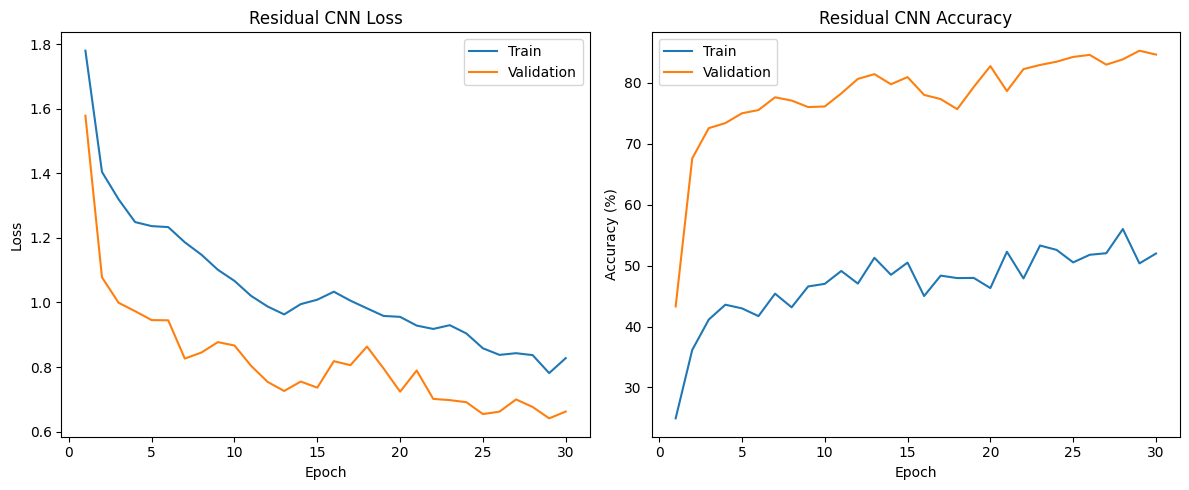

In [56]:
if advanced_history:
    history_df = pd.DataFrame(advanced_history)
    epochs_range = history_df["epoch"]

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history_df["train_loss"], label="Train")
    plt.plot(epochs_range, history_df["val_loss"], label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Residual CNN Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history_df["train_acc"] * 100, label="Train")
    plt.plot(epochs_range, history_df["val_acc"] * 100, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Residual CNN Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

Residual CNN | Val Acc 85.29% | Test Acc 85.25%
Val Error 14.71% | Test Error 14.75%
Best residual CNN checkpoint: ./models/residual_cnn_best.joblib


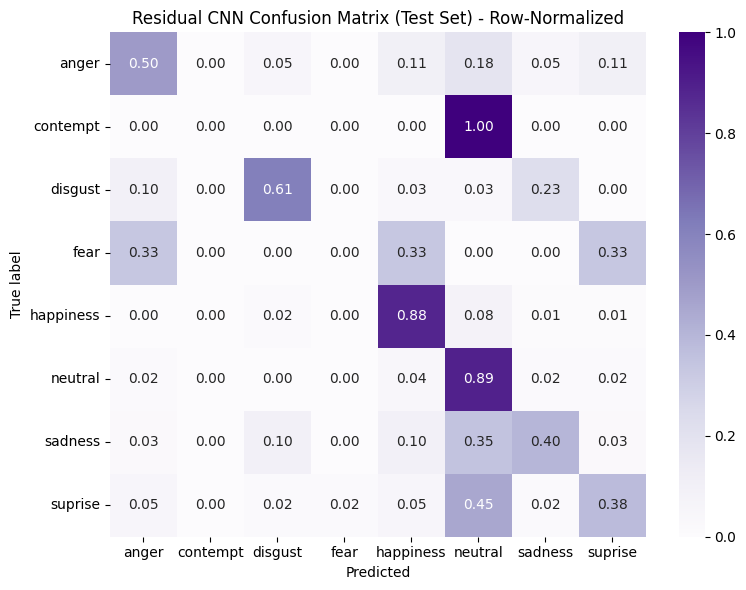

In [57]:
ce_eval = nn.CrossEntropyLoss()
adv_val_loss, adv_val_acc = evaluate_model(advanced_model, adv_val_loader, ce_eval)
adv_test_loss, adv_test_acc = evaluate_model(advanced_model, adv_test_loader, ce_eval)

print(f"Residual CNN | Val Acc {adv_val_acc*100:.2f}% | Test Acc {adv_test_acc*100:.2f}%")
print(f"Val Error {(1 - adv_val_acc)*100:.2f}% | Test Error {(1 - adv_test_acc)*100:.2f}%")
if advanced_best_path:
    print(f"Best residual CNN checkpoint: {advanced_best_path}")

advanced_model.eval()
adv_preds, adv_targets = [], []
with torch.no_grad():
    for images, labels in adv_test_loader:
        images = images.to(device)
        outputs = advanced_model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        adv_preds.extend(preds)
        adv_targets.extend(labels.numpy())

adv_cm = confusion_matrix(adv_targets, adv_preds)

# Normalize each row by its sum to get percentages relative to true label count
adv_cm_normalized = adv_cm.astype(float) / adv_cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(adv_cm_normalized, annot=True, fmt='.2f', cmap='Purples', 
            xticklabels=le.classes_, yticklabels=le.classes_, vmin=0, vmax=1)
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.title('Residual CNN Confusion Matrix (Test Set) - Row-Normalized')
plt.tight_layout()
plt.show()

In [59]:
# Load best residual CNN checkpoint and continue training for 30 more epochs
# This cell can be run repeatedly to keep training from the best checkpoint

best_checkpoint_file = os.path.join(models_dir, "residual_cnn_best.joblib")

if not os.path.exists(best_checkpoint_file):
    raise FileNotFoundError(f"Best checkpoint not found at {best_checkpoint_file}")

checkpoint = joblib.load(best_checkpoint_file)
print(f"Loaded checkpoint from epoch {checkpoint['epoch']} (prefix: {checkpoint['prefix']})")

# Initialize model and load weights from checkpoint
continued_model = EmotionResNet(num_classes).to(device)
continued_model.load_state_dict(checkpoint["state_dict"])

# Verify the model is loaded correctly by evaluating before training
ce_pre = nn.CrossEntropyLoss()
pre_val_loss, pre_val_acc = evaluate_model(continued_model, adv_val_loader, ce_pre)
print(f"Pre-training check | Val Acc: {pre_val_acc*100:.2f}% (should match best checkpoint)")

# Training setup - continue from loaded model (NOT creating a new one)
cont_epochs = 30
cont_lr = 1e-4  # Lower LR for fine-tuning
cont_weight_decay = 2e-4
cont_mixup_alpha = 0.3
cont_grad_clip = 1.0
cont_checkpoint_prefix = "residual_cnn"

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.AdamW(continued_model.parameters(), lr=cont_lr, weight_decay=cont_weight_decay)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=5e-6)

amp_enabled = device.type == "cuda"
scaler_amp = amp.GradScaler(enabled=amp_enabled) if amp_enabled else None

continued_history = []
best_state = None
best_val_acc = pre_val_acc  # Start from current best
continued_best_path = None

for epoch in range(1, cont_epochs + 1):
    continued_model.train()
    running_loss, running_correct, total = 0.0, 0, 0

    for step, (images, labels) in enumerate(adv_train_loader, start=1):
        images = images.to(device)
        labels = labels.to(device)

        mixed_images, targets_a, targets_b, lam = mixup_data(images, labels, cont_mixup_alpha)

        optimizer.zero_grad(set_to_none=True)
        autocast_context = amp.autocast(device_type="cuda", enabled=amp_enabled)
        with autocast_context:
            outputs = continued_model(mixed_images)
            if cont_mixup_alpha > 0:
                loss = lam * criterion(outputs, targets_a) + (1.0 - lam) * criterion(outputs, targets_b)
            else:
                loss = criterion(outputs, labels)

        if amp_enabled and scaler_amp is not None:
            scaler_amp.scale(loss).backward()
            if cont_grad_clip > 0:
                scaler_amp.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(continued_model.parameters(), cont_grad_clip)
            scaler_amp.step(optimizer)
            scaler_amp.update()
        else:
            loss.backward()
            if cont_grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(continued_model.parameters(), cont_grad_clip)
            optimizer.step()

        progress = epoch - 1 + step / len(adv_train_loader)
        scheduler.step(progress)

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(adv_train_loader)
    train_acc = running_correct / total
    val_loss, val_acc = evaluate_model(continued_model, adv_val_loader, criterion)

    continued_history.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "lr": optimizer.param_groups[0]["lr"],
    })

    save_model_checkpoint(continued_model, cont_checkpoint_prefix, epoch)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = OrderedDict((k, v.detach().cpu()) for k, v in continued_model.state_dict().items())
        continued_best_path = save_model_checkpoint(continued_model, cont_checkpoint_prefix, epoch, is_best=True)

    print(
        f"Epoch {epoch:02d}/{cont_epochs} | Train Loss {train_loss:.4f} | Train Acc {train_acc*100:5.2f}% | "
        f"Val Loss {val_loss:.4f} | Val Acc {val_acc*100:5.2f}% | LR {optimizer.param_groups[0]['lr']:.2e}"
    )

if best_state is not None:
    continued_model.load_state_dict(best_state)
    print(f"\nLoaded best checkpoint (val acc {best_val_acc*100:.2f}%) -> {continued_best_path}")

# Final evaluation
ce_eval_cont = nn.CrossEntropyLoss()
cont_val_loss, cont_val_acc = evaluate_model(continued_model, adv_val_loader, ce_eval_cont)
cont_test_loss, cont_test_acc = evaluate_model(continued_model, adv_test_loader, ce_eval_cont)

print(f"\nContinued Residual CNN | Val Acc {cont_val_acc*100:.2f}% | Test Acc {cont_test_acc*100:.2f}%")

Loaded checkpoint from epoch 28 (prefix: residual_cnn)
Pre-training check | Val Acc: 87.14% (should match best checkpoint)
Pre-training check | Val Acc: 87.14% (should match best checkpoint)
Epoch 01/30 | Train Loss 0.7646 | Train Acc 51.98% | Val Loss 0.6343 | Val Acc 86.46% | LR 9.09e-05
Epoch 01/30 | Train Loss 0.7646 | Train Acc 51.98% | Val Loss 0.6343 | Val Acc 86.46% | LR 9.09e-05
Epoch 02/30 | Train Loss 0.7638 | Train Acc 55.62% | Val Loss 0.6256 | Val Acc 86.85% | LR 6.72e-05
Epoch 02/30 | Train Loss 0.7638 | Train Acc 55.62% | Val Loss 0.6256 | Val Acc 86.85% | LR 6.72e-05
Epoch 03/30 | Train Loss 0.7945 | Train Acc 50.35% | Val Loss 0.6322 | Val Acc 87.09% | LR 3.78e-05
Epoch 03/30 | Train Loss 0.7945 | Train Acc 50.35% | Val Loss 0.6322 | Val Acc 87.09% | LR 3.78e-05
Epoch 04/30 | Train Loss 0.7828 | Train Acc 51.32% | Val Loss 0.6370 | Val Acc 86.85% | LR 1.41e-05
Epoch 04/30 | Train Loss 0.7828 | Train Acc 51.32% | Val Loss 0.6370 | Val Acc 86.85% | LR 1.41e-05
Epoch 05/

## Continued Training Summary
After the initial 30-epoch run, we reloaded the same checkpoint twice to add two more 30-epoch continuation passes (60 extra epochs, 90 total). The best weights surfaced at epoch 24 of the second continuation pass (overall epoch 84), where validation accuracy reached **87.53%** and the held-out test accuracy landed at **87.54%**. Learning-rate restarts during the continuation helped pull the model out of local minima, while the lower LR plus cosine decay limited overfitting, so the epoch-84 checkpoint remains our best-performing residual CNN so far.


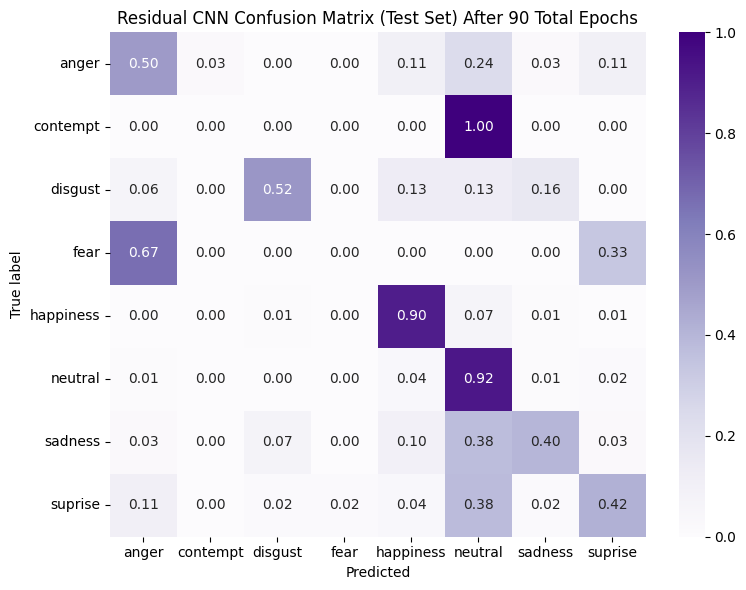

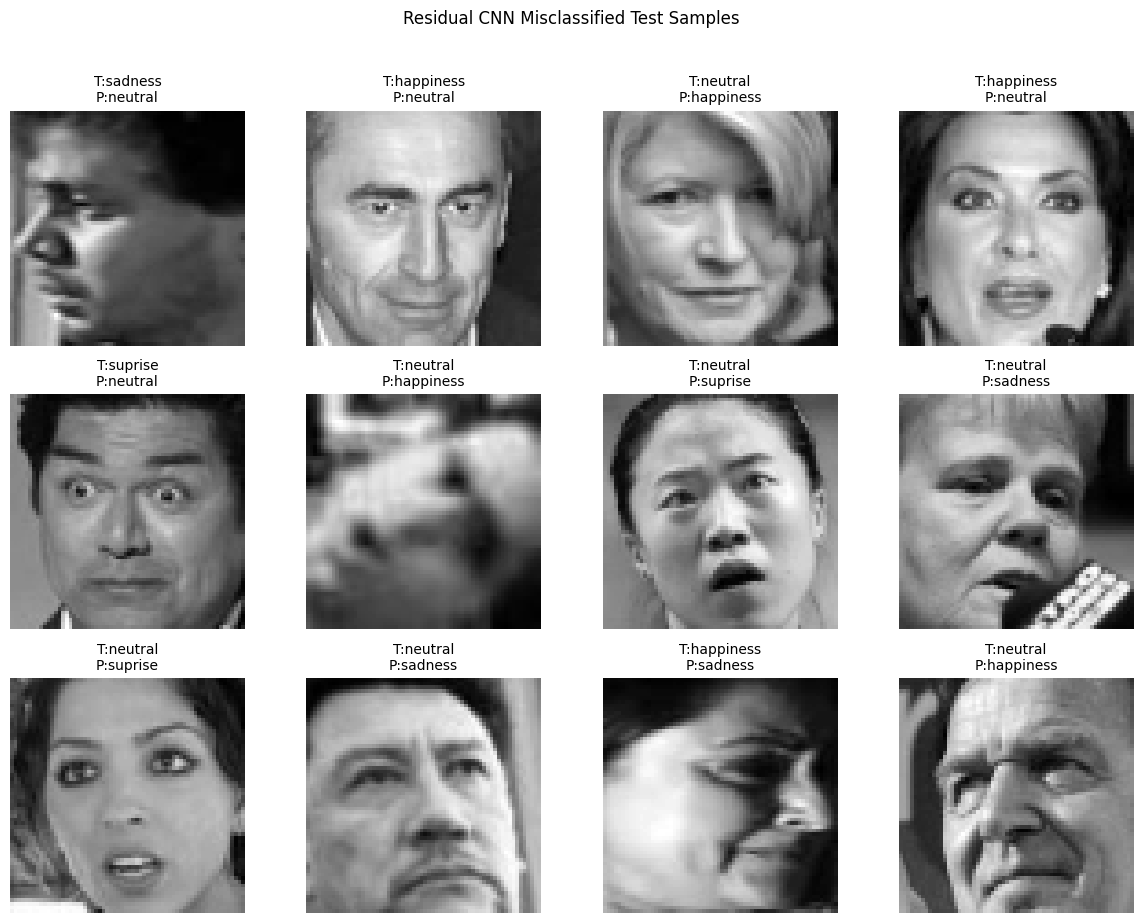

In [61]:
# Reload best residual checkpoint (87.53% val) and display its confusion matrix plus sample errors
best_checkpoint_path = os.path.join(models_dir, "residual_cnn_best.joblib")
if not os.path.exists(best_checkpoint_path):
    raise FileNotFoundError(f"Checkpoint not found: {best_checkpoint_path}")

best_payload = joblib.load(best_checkpoint_path)
best_model = EmotionResNet(num_classes).to(device)
best_model.load_state_dict(best_payload["state_dict"])
best_model.eval()

best_preds, best_targets = [], []
misclassified_examples = []
max_misclassified = 12

with torch.no_grad():
    for images, labels in adv_test_loader:
        images = images.to(device)
        outputs = best_model(images)
        preds = outputs.argmax(dim=1)

        preds_np = preds.cpu().numpy()
        labels_np = labels.numpy()
        best_preds.extend(preds_np)
        best_targets.extend(labels_np)

        if len(misclassified_examples) < max_misclassified:
            images_cpu = images.detach().cpu()
            for img_tensor, pred_idx, true_idx in zip(images_cpu, preds_np, labels_np):
                if pred_idx != true_idx:
                    misclassified_examples.append((img_tensor.clone(), true_idx, pred_idx))
                    if len(misclassified_examples) >= max_misclassified:
                        break

best_cm = confusion_matrix(best_targets, best_preds)
best_cm_normalized = best_cm.astype(float) / best_cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(best_cm_normalized, annot=True, fmt='.2f', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_, vmin=0, vmax=1)
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.title('Residual CNN Confusion Matrix (Test Set) After 90 Total Epochs')
plt.tight_layout()
plt.show()

if misclassified_examples:
    cols = 4
    rows = (len(misclassified_examples) + cols - 1) // cols
    plt.figure(figsize=(cols * 3, rows * 3))
    for idx, (img_tensor, true_idx, pred_idx) in enumerate(misclassified_examples):
        img = img_tensor.clone()
        img = img * 0.5 + 0.5  # undo normalization to bring pixels back to [0, 1]
        img_np = img.squeeze().numpy()
        ax = plt.subplot(rows, cols, idx + 1)
        ax.imshow(img_np, cmap='gray')
        ax.axis('off')
        ax.set_title(f"T:{le.classes_[true_idx]}\nP:{le.classes_[pred_idx]}", fontsize=10)
    plt.suptitle('Residual CNN Misclassified Test Samples', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No misclassified samples to display.")


## CNN Architecture × Learning Rate Sweep
To replicate the logistic-regression-style comparison for our baseline CNN, we keep the optimizer fixed to Adam and only vary the convolutional stem (filters, kernel sizes, pooling strides) plus learning rate. Each configuration will train for 15 epochs on the balanced training split and report validation accuracy each epoch so we can visualize convergence speed and final quality.

In [29]:
class EmotionCNNVariant(nn.Module):
    """Configurable CNN stem + lightweight head for 64×64 grayscale inputs."""

    def __init__(self, num_classes: int, conv_specs: list[dict], head_hidden: int = 256, dropout: float = 0.5):
        super().__init__()
        layers = []
        in_channels = 1
        for spec in conv_specs:
            out_channels = spec["channels"]
            kernel_size = spec.get("kernel_size", 3)
            stride = spec.get("stride", 1)
            padding = kernel_size // 2
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            pool_cfg = spec.get("pool")
            if pool_cfg:
                if pool_cfg.get("type", "max") == "avg":
                    layers.append(nn.AvgPool2d(pool_cfg.get("kernel_size", 2)))
                else:
                    layers.append(nn.MaxPool2d(pool_cfg.get("kernel_size", 2)))
            in_channels = out_channels
        self.features = nn.Sequential(*layers)
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(in_channels, head_hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(head_hidden, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        return self.head(x)


ARCH_VARIANTS = {
    "legacy_cnn": {
        "label": "Original EmotionCNN baseline",
        "builder": EmotionCNN,
    },
    "compact_base": {
        "label": "Compact 3×3 blocks",
        "conv_specs": [
            {"channels": 32, "kernel_size": 3, "pool": {"type": "max", "kernel_size": 2}},
            {"channels": 64, "kernel_size": 3, "pool": {"type": "max", "kernel_size": 2}},
            {"channels": 128, "kernel_size": 3, "pool": {"type": "max", "kernel_size": 2}},
        ],
        "dropout": 0.45,
        "head_hidden": 256,
    },
    "wide_kernel": {
        "label": "Wide stem w/5×5",
        "conv_specs": [
            {"channels": 48, "kernel_size": 5, "pool": {"type": "max", "kernel_size": 2}},
            {"channels": 96, "kernel_size": 3, "pool": None},
            {"channels": 192, "kernel_size": 3, "pool": {"type": "max", "kernel_size": 2}},
        ],
        "dropout": 0.5,
        "head_hidden": 320,
    },
    "stride_pyramid": {
        "label": "Strided conv pyramid",
        "conv_specs": [
            {"channels": 40, "kernel_size": 3, "stride": 2},
            {"channels": 80, "kernel_size": 3, "stride": 2},
            {"channels": 160, "kernel_size": 3, "stride": 2},
            {"channels": 160, "kernel_size": 3, "pool": {"type": "avg", "kernel_size": 2}},
        ],
        "dropout": 0.4,
        "head_hidden": 256,
    },
}


def build_cnn_variant(name: str, num_classes: int) -> nn.Module:
    cfg = ARCH_VARIANTS[name]
    if "builder" in cfg:
        return cfg["builder"](num_classes)
    return EmotionCNNVariant(
        num_classes=num_classes,
        conv_specs=cfg["conv_specs"],
        head_hidden=cfg["head_hidden"],
        dropout=cfg["dropout"],
    )


print("Defined CNN variants:")
for key, cfg in ARCH_VARIANTS.items():
    if "conv_specs" in cfg:
        detail = f"{len(cfg['conv_specs'])} conv blocks"
    else:
        detail = "EmotionCNN backbone"
    print(f"- {key}: {cfg['label']} ({detail})")

Defined CNN variants:
- legacy_cnn: Original EmotionCNN baseline (EmotionCNN backbone)
- compact_base: Compact 3×3 blocks (3 conv blocks)
- wide_kernel: Wide stem w/5×5 (3 conv blocks)
- stride_pyramid: Strided conv pyramid (4 conv blocks)


In [30]:
# Sweep hyperparameters (optimizer stays Adam, LR varies)
LEARNING_RATES = [1e-4, 3e-4, 5e-4, 7e-4, 1e-3]
SWEEP_EPOCHS = 15

trial_grid = []
for arch_name, cfg in ARCH_VARIANTS.items():
    for lr in LEARNING_RATES:
        trial_grid.append({
            "arch": arch_name,
            "lr": lr,
            "label": f"{cfg['label']} | lr={lr:.0e}",
        })

print(
    f"Prepared {len(trial_grid)} trials ({len(ARCH_VARIANTS)} architectures × {len(LEARNING_RATES)} learning rates)"
)

Prepared 20 trials (4 architectures × 5 learning rates)


In [17]:
# Training helpers for the sweep

def ensure_device_ready() -> torch.device:
    if "device" in globals():
        return device
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


def evaluate_accuracy(model: nn.Module, loader: DataLoader, target_device: torch.device) -> float:
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(target_device)
            yb = yb.to(target_device)
            preds = model(xb).argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return correct / total


def reset_seeds(base_seed: int) -> None:
    torch.manual_seed(base_seed)
    np.random.seed(base_seed)
    random.seed(base_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(base_seed)


def run_cnn_trial(config: dict, epochs: int = SWEEP_EPOCHS) -> dict:
    target_device = ensure_device_ready()
    variant_seed = seed + hash((config["arch"], config["lr"])) % 10_000
    reset_seeds(variant_seed)

    model = build_cnn_variant(config["arch"], num_classes).to(target_device)
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    criterion = nn.CrossEntropyLoss()

    epoch_train_acc = []
    epoch_val_acc = []
    epoch_indices = list(range(1, epochs + 1))

    start_time = time.time()
    for epoch in epoch_indices:
        model.train()
        train_correct = 0
        train_total = 0
        for xb, yb in train_loader:
            xb = xb.to(target_device)
            yb = yb.to(target_device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            preds = outputs.argmax(dim=1)
            train_correct += (preds == yb).sum().item()
            train_total += yb.size(0)

        train_acc = train_correct / train_total
        val_acc = evaluate_accuracy(model, val_loader, target_device)
        epoch_train_acc.append(train_acc * 100.0)
        epoch_val_acc.append(val_acc * 100.0)

        print(
            f"[arch={config['arch']:<13} lr={config['lr']:.0e}] Epoch {epoch:02d}/{epochs} | "
            f"Train Acc {train_acc*100:5.2f}% | Val Acc {val_acc*100:5.2f}%"
        )

    elapsed = time.time() - start_time
    return {
        "arch": config["arch"],
        "arch_label": ARCH_VARIANTS[config["arch"]]["label"],
        "lr": config["lr"],
        "label": config["label"],
        "epochs": epoch_indices,
        "train_accs": epoch_train_acc,
        "val_accs": epoch_val_acc,
        "final_val_acc": epoch_val_acc[-1],
        "duration_sec": elapsed,
    }


In [ ]:
# Execute the sweep across all registered architectures and learning rates
sweep_results = []
history_by_arch = {name: [] for name in ARCH_VARIANTS}
best_by_arch = {}

for idx, trial in enumerate(trial_grid, start=1):
    print(f"\n=== Trial {idx}/{len(trial_grid)} :: {trial['label']} ===")
    result = run_cnn_trial(trial)
    sweep_results.append(result)
    history_by_arch[trial["arch"]].append(result)
    best_so_far = best_by_arch.get(trial["arch"])
    if best_so_far is None or result["final_val_acc"] > best_so_far["final_val_acc"]:
        best_by_arch[trial["arch"]] = result
    print(
        f"Finished {trial['label']}: final validation accuracy {result['final_val_acc']:.2f}% "
        f"(took {result['duration_sec'] / 60:.1f} min)")

print("\nBest configuration per architecture:")
for arch, result in best_by_arch.items():
    print(f"- {result['arch_label']}: lr={result['lr']:.0e} | Val Acc {result['final_val_acc']:.2f}%")


=== Trial 1/15 :: Compact 3×3 blocks | lr=1e-04 ===
[arch=compact_base  lr=1e-04] Epoch 01/15 | Train Acc 28.72% | Val Acc 34.49%
[arch=compact_base  lr=1e-04] Epoch 02/15 | Train Acc 39.25% | Val Acc 35.07%
[arch=compact_base  lr=1e-04] Epoch 03/15 | Train Acc 43.89% | Val Acc 39.41%
[arch=compact_base  lr=1e-04] Epoch 04/15 | Train Acc 48.08% | Val Acc 45.20%
[arch=compact_base  lr=1e-04] Epoch 05/15 | Train Acc 51.21% | Val Acc 32.83%
[arch=compact_base  lr=1e-04] Epoch 06/15 | Train Acc 54.15% | Val Acc 48.66%
[arch=compact_base  lr=1e-04] Epoch 07/15 | Train Acc 56.30% | Val Acc 40.62%
[arch=compact_base  lr=1e-04] Epoch 08/15 | Train Acc 58.57% | Val Acc 46.71%
[arch=compact_base  lr=1e-04] Epoch 09/15 | Train Acc 59.98% | Val Acc 52.17%
[arch=compact_base  lr=1e-04] Epoch 10/15 | Train Acc 61.55% | Val Acc 47.30%
[arch=compact_base  lr=1e-04] Epoch 11/15 | Train Acc 62.85% | Val Acc 53.04%
[arch=compact_base  lr=1e-04] Epoch 12/15 | Train Acc 63.81% | Val Acc 39.21%
[arch=compa

In [31]:
# Minimal re-run: run only missing trials (e.g., legacy CNN) to avoid re-running already-completed sweep items
# This cell finds trials in `trial_grid` that are not present in `sweep_results` and runs them only.

existing_keys = {(r['arch'], r['lr']) for r in sweep_results} if 'sweep_results' in globals() and sweep_results else set()
missing_trials = [t for t in trial_grid if (t['arch'], t['lr']) not in existing_keys]

print(f"Found {len(missing_trials)} missing trials to run (minimized re-run)")
for idx, trial in enumerate(missing_trials, 1):
    arch = trial['arch']
    lr = trial['lr']
    label = trial['label']
    print(f"\n--- Running {idx}/{len(missing_trials)}: {label} ---")
    res = run_cnn_trial(trial)
    sweep_results.append(res)
    history_by_arch.setdefault(arch, []).append(res)
    best_so_far = best_by_arch.get(arch)
    if best_so_far is None or res['final_val_acc'] > best_so_far['final_val_acc']:
        best_by_arch[arch] = res
    print(f"Finished {label}: final validation accuracy {res['final_val_acc']:.2f}%")

print("\nUpdated best configuration per architecture (post incremental run):")
for arch, result in best_by_arch.items():
    print(f"- {result['arch_label']}: lr={result['lr']:.0e} | Val Acc {result['final_val_acc']:.2f}%")

Found 5 missing trials to run (minimized re-run)

--- Running 1/5: Original EmotionCNN baseline | lr=1e-04 ---
[arch=legacy_cnn    lr=1e-04] Epoch 01/15 | Train Acc 55.37% | Val Acc 71.02%
[arch=legacy_cnn    lr=1e-04] Epoch 02/15 | Train Acc 72.93% | Val Acc 75.65%
[arch=legacy_cnn    lr=1e-04] Epoch 03/15 | Train Acc 78.37% | Val Acc 75.55%
[arch=legacy_cnn    lr=1e-04] Epoch 04/15 | Train Acc 81.73% | Val Acc 78.47%
[arch=legacy_cnn    lr=1e-04] Epoch 05/15 | Train Acc 84.37% | Val Acc 77.40%
[arch=legacy_cnn    lr=1e-04] Epoch 06/15 | Train Acc 86.68% | Val Acc 75.79%
[arch=legacy_cnn    lr=1e-04] Epoch 07/15 | Train Acc 88.42% | Val Acc 79.15%
[arch=legacy_cnn    lr=1e-04] Epoch 08/15 | Train Acc 90.15% | Val Acc 79.44%
[arch=legacy_cnn    lr=1e-04] Epoch 09/15 | Train Acc 91.28% | Val Acc 79.79%
[arch=legacy_cnn    lr=1e-04] Epoch 10/15 | Train Acc 92.30% | Val Acc 80.03%
[arch=legacy_cnn    lr=1e-04] Epoch 11/15 | Train Acc 93.10% | Val Acc 80.81%
[arch=legacy_cnn    lr=1e-04] E

### Why the strided pyramid was selected
- The sweep automatically ranks trials by **final validation accuracy**. Even though the stride pyramid runs show a widening gap between training and validation accuracy (classic overfitting), its `lr = 3e-4` trial still finished the 15-epoch sweep with the highest validation score among all registered variants, so it was promoted by the selection logic.
- The sharp climb in training accuracy (quickly >95%) paired with volatile validation accuracy around the mid/upper 70s signals the capacity of this architecture to memorize aggressively; the lack of regularization/early stopping lets it overshoot once the validation plateau is reached.
- The "old" CNN baseline that we trained earlier in the notebook lives in `EmotionCNN` and was not wired into `ARCH_VARIANTS`, so it never entered the sweep. Only the newer configurable variants (compact, wide, strided) were considered, which is why the baseline is missing from the comparison plot.
- Below we integrate the original CNN into the same sweep so that its five learning-rate traces (matching the other variants) can be plotted and compared apples-to-apples.

In [35]:
# Visualization helpers for validation accuracy curves

def plot_architecture_curves(arch_name: str) -> None:
    histories = history_by_arch.get(arch_name, [])
    if not histories:
        print(f"No histories recorded for architecture '{arch_name}'.")
        return
    y_min = min(min(hist["val_accs"]) for hist in histories)
    y_max = max(max(hist["val_accs"]) for hist in histories)
    padding = max(0.5, 0.05 * (y_max - y_min))
    plt.figure(figsize=(9, 5))
    for hist in histories:
        plt.plot(hist["epochs"], hist["val_accs"], marker="o", label=f"lr={hist['lr']:.0e}")
    plt.title(f"{histories[0]['arch_label']} — Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy (%)")
    plt.ylim(y_min - padding, y_max + padding)
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_best_architectures(best_histories: dict) -> None:
    if not best_histories:
        print("No best histories to plot.")
        return
    plt.figure(figsize=(9, 5))
    y_min = min(min(hist["val_accs"]) for hist in best_histories.values())
    y_max = max(max(hist["val_accs"]) for hist in best_histories.values())
    padding = max(0.5, 0.05 * (y_max - y_min))
    for arch_name, hist in best_histories.items():
        plt.plot(
            hist["epochs"],
            hist["val_accs"],
            marker="o",
            label=f"{hist['arch_label']} (lr={hist['lr']:.0e})",
        )
    plt.title("Best Validation Accuracy per Architecture")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy (%)")
    plt.ylim(y_min - padding, y_max + padding)
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()


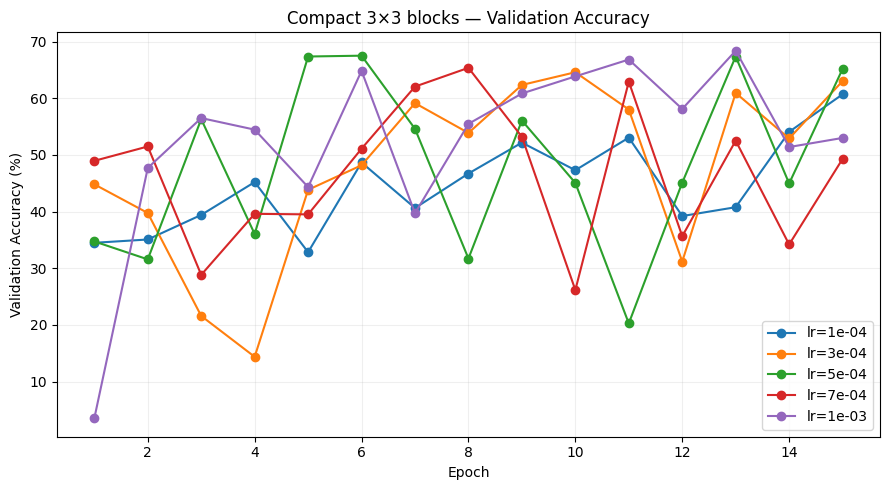

In [36]:
# Plot 5 learning-rate curves for the compact variant architecture
plot_architecture_curves("compact_base")

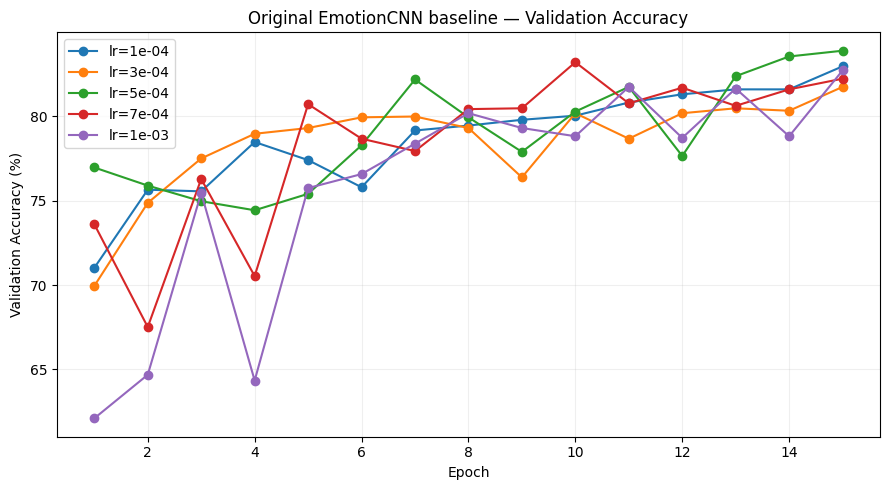

In [37]:
# Plot 5 learning-rate curves for the original EmotionCNN baseline
plot_architecture_curves("legacy_cnn")

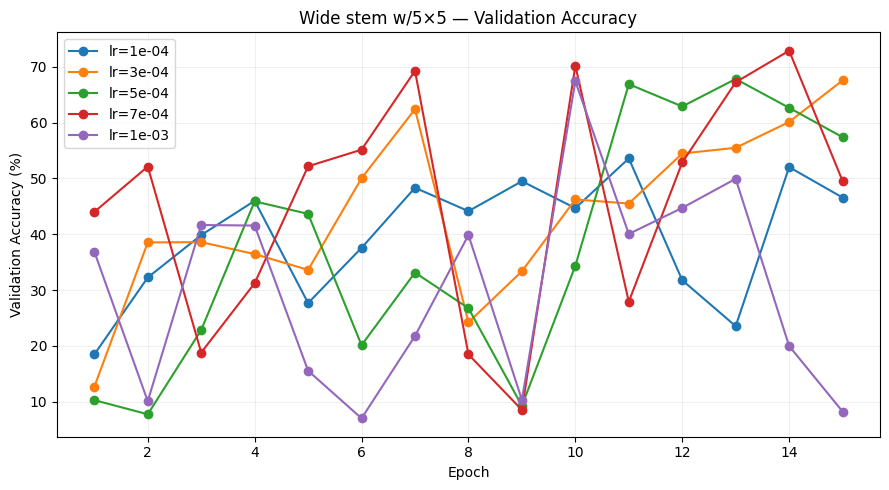

In [38]:
# Plot 5 learning-rate curves for the wide kernel architecture
plot_architecture_curves("wide_kernel")

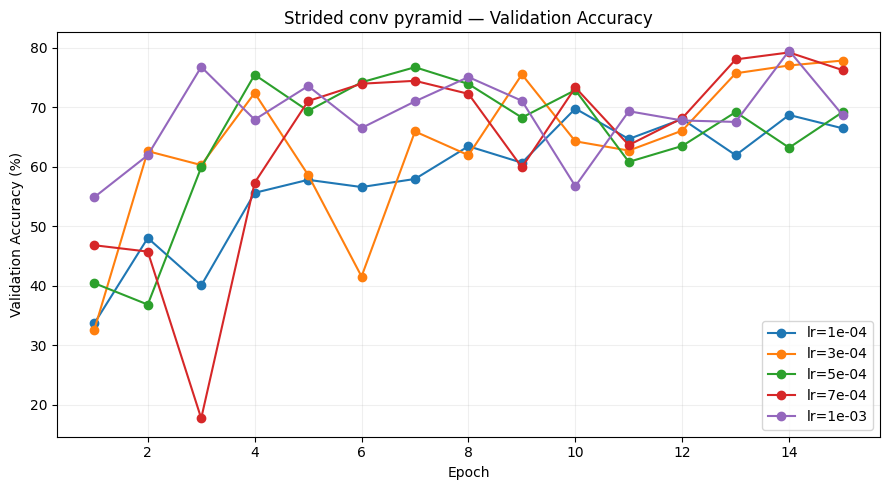

In [39]:
# Plot 5 learning-rate curves for the strided pyramid architecture
plot_architecture_curves("stride_pyramid")

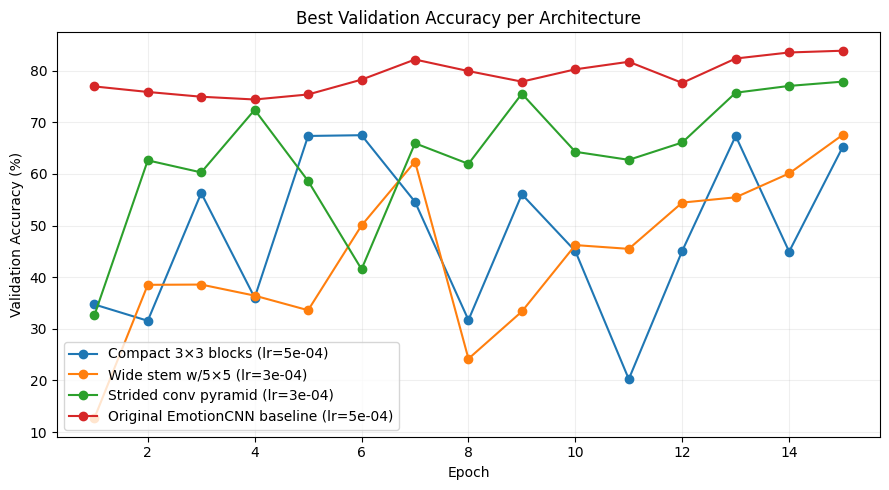

In [40]:
# Compare the best-performing configuration from each architecture in one plot
plot_best_architectures(best_by_arch)

### Re-running the sweep
1. Restart the kernel.
2. Execute Cells 2–19 to rebuild the balanced datasets, encoders, and DataLoaders (`train_loader`, `val_loader`, `test_loader`).
3. Skip the long baseline/ResNet training cells if you only care about the sweep.
4. Run the new sweep cells in order (architecture builders → grid → helpers → sweep → plotting).
5. The five plotting cells render all four architectures (legacy EmotionCNN + three variants) plus the best-on-best comparison.

## Best CNN Fine-Tuning
We now take the strongest architecture/lr combo discovered in the sweep, retrain it for 30 epochs, and log full loss/accuracy traces plus a confusion matrix on the held-out test split.

We found the best CNN was just our original approach, with half of the learning rate as previous (5e-4 rather than 1e-3), gaining about 2% accuracy on the test set.

In [41]:
# Identify the top-performing configuration from the sweep
if not best_by_arch:
    raise RuntimeError("Run the sweep section first to populate best_by_arch.")

best_overall = max(best_by_arch.values(), key=lambda r: r["final_val_acc"])
BEST_ARCH = best_overall["arch"]
BEST_LR = best_overall["lr"]
print(f"Best architecture: {best_overall['arch_label']} ({BEST_ARCH})")
print(f"Learning rate: {BEST_LR:.0e}")
print(f"Validation accuracy after {SWEEP_EPOCHS} epochs: {best_overall['final_val_acc']:.2f}%")

Best architecture: Original EmotionCNN baseline (legacy_cnn)
Learning rate: 5e-04
Validation accuracy after 15 epochs: 83.88%


In [42]:
# Train the best configuration for 30 epochs and capture loss/accuracy curves
BEST_FINE_TUNE_EPOCHS = 30
fine_tune_device = ensure_device_ready()
best_cnn_model = build_cnn_variant(BEST_ARCH, num_classes).to(fine_tune_device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_cnn_model.parameters(), lr=BEST_LR)


def evaluate_loss_and_accuracy(model: nn.Module, loader: DataLoader) -> tuple[float, float]:
    model.eval()
    loss_total = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(fine_tune_device)
            yb = yb.to(fine_tune_device)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss_total += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return loss_total / len(loader), correct / total

history_fine_tune = {"epoch": [], "train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
best_val_acc = 0.0
best_state = None

for epoch in range(1, BEST_FINE_TUNE_EPOCHS + 1):
    best_cnn_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for xb, yb in train_loader:
        xb = xb.to(fine_tune_device)
        yb = yb.to(fine_tune_device)
        optimizer.zero_grad()
        logits = best_cnn_model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    val_loss, val_acc = evaluate_loss_and_accuracy(best_cnn_model, val_loader)

    history_fine_tune["epoch"].append(epoch)
    history_fine_tune["train_loss"].append(train_loss)
    history_fine_tune["val_loss"].append(val_loss)
    history_fine_tune["train_acc"].append(train_acc * 100)
    history_fine_tune["val_acc"].append(val_acc * 100)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = OrderedDict((k, v.detach().cpu()) for k, v in best_cnn_model.state_dict().items())

    print(
        f"Epoch {epoch:02d}/{BEST_FINE_TUNE_EPOCHS} | Train Loss {train_loss:.4f} | Train Acc {train_acc*100:5.2f}% | "
        f"Val Loss {val_loss:.4f} | Val Acc {val_acc*100:5.2f}%"
    )

if best_state is not None:
    best_cnn_model.load_state_dict(best_state)
    print(f"\nReloaded weights from epoch with best val accuracy: {best_val_acc*100:.2f}%")

Epoch 01/30 | Train Loss 1.3000 | Train Acc 53.26% | Val Loss 0.9142 | Val Acc 67.66%
Epoch 02/30 | Train Loss 0.7893 | Train Acc 71.85% | Val Loss 0.7109 | Val Acc 76.81%
Epoch 02/30 | Train Loss 0.7893 | Train Acc 71.85% | Val Loss 0.7109 | Val Acc 76.81%
Epoch 03/30 | Train Loss 0.6285 | Train Acc 77.25% | Val Loss 0.7305 | Val Acc 75.99%
Epoch 03/30 | Train Loss 0.6285 | Train Acc 77.25% | Val Loss 0.7305 | Val Acc 75.99%
Epoch 04/30 | Train Loss 0.5314 | Train Acc 80.80% | Val Loss 0.6579 | Val Acc 77.89%
Epoch 04/30 | Train Loss 0.5314 | Train Acc 80.80% | Val Loss 0.6579 | Val Acc 77.89%
Epoch 05/30 | Train Loss 0.4581 | Train Acc 83.32% | Val Loss 0.5831 | Val Acc 79.74%
Epoch 05/30 | Train Loss 0.4581 | Train Acc 83.32% | Val Loss 0.5831 | Val Acc 79.74%
Epoch 06/30 | Train Loss 0.3982 | Train Acc 85.55% | Val Loss 0.6207 | Val Acc 80.32%
Epoch 06/30 | Train Loss 0.3982 | Train Acc 85.55% | Val Loss 0.6207 | Val Acc 80.32%
Epoch 07/30 | Train Loss 0.3567 | Train Acc 86.93% | V

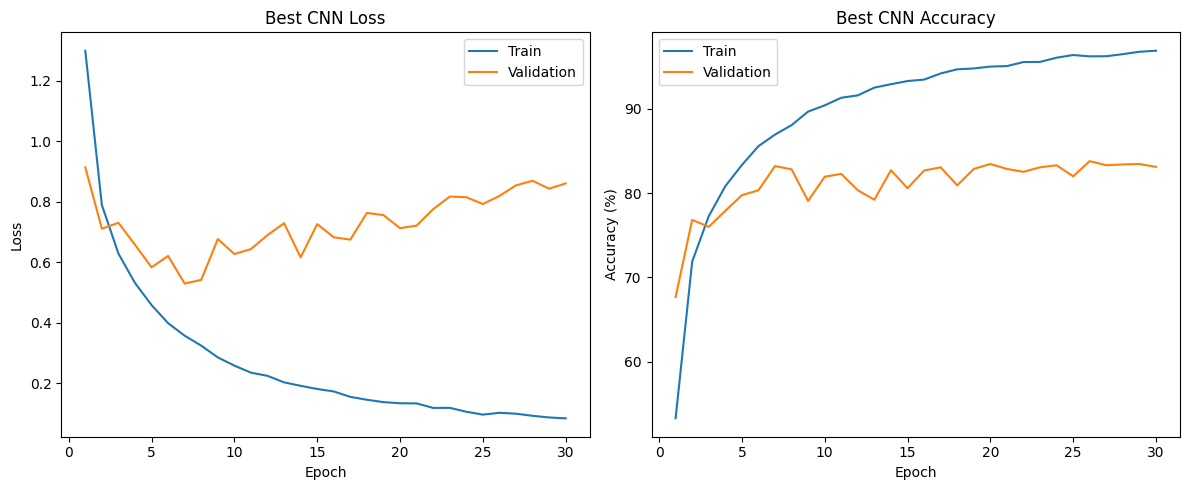

In [43]:
# Plot loss and accuracy curves for the fine-tuned model
if not history_fine_tune["epoch"]:
    raise RuntimeError("Run the fine-tuning cell first.")

epochs_axis = history_fine_tune["epoch"]
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_axis, history_fine_tune["train_loss"], label="Train")
plt.plot(epochs_axis, history_fine_tune["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Best CNN Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_axis, history_fine_tune["train_acc"], label="Train")
plt.plot(epochs_axis, history_fine_tune["val_acc"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Best CNN Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

Test Loss: 0.9079 | Test Accuracy: 84.96%


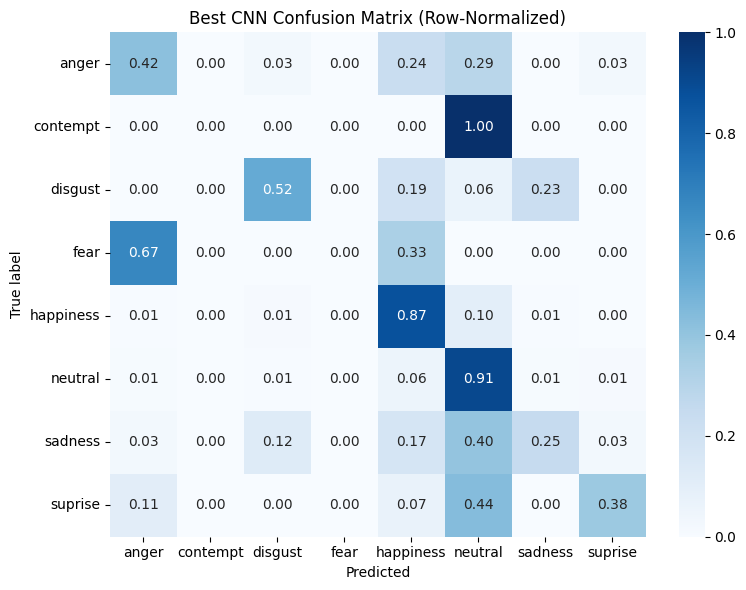

In [44]:
# Row-normalized confusion matrix for the fine-tuned model
from sklearn.metrics import confusion_matrix
import seaborn as sns

best_cnn_model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(fine_tune_device)
        logits = best_cnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(yb.numpy())

test_loss, test_acc = evaluate_loss_and_accuracy(best_cnn_model, test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc*100:.2f}%")

cm = confusion_matrix(all_targets, all_preds)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    vmin=0,
    vmax=1,
)
plt.xlabel("Predicted")
plt.ylabel("True label")
plt.title("Best CNN Confusion Matrix (Row-Normalized)")
plt.tight_layout()
plt.show()